The equation for `x_reward_value_chosen` resembles basically the reward-prediction error.

The reward-prediction error is fairly well understood in cognitive science - also thanks to neuroimaging studies, which underlie the assumption about the classic mathematical form.

Therefore, the possible novel findings are quite limited here. 
The learning rate on the other hand is in many studies assumed to be a constant and is also embedded in the SINDy equation as a fixed parameter. 
It can of course model asymmetric learning rates for rewards and penalties but is not adapting dynamically. 

So what if we would like to find a dynamical equation which describes how the learning rate could possibly change with respect to rewards or the current value `x_reward_value_chosen`? 

The problem here is that we cannot just add another RNN-module in-line with `x_reward_value_chosen` which processes the same inputs.

This would result in two modules which would not have unique solutions.

Therefore, we have to disentangle here by adding knowledge about `x_reward_value_chosen` in the form of the classic reward-prediction error.

That way we are ending up with an additional RNN-module in the form of a hard-coded equation, and we have to expand the memory state by one variable which is the learning rate `x_learning_rate_reward`. 

Additionally, we are going to set the initial values for all memory state variables.

In the next section you will learn how to add hard-coded equations to the RNN.

In [1]:
from spice.resources.rnn import BaseRNN
import torch

/Users/imtezcan/Repositories/CogSci/SPICE/SPICE/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
class RLRNN(BaseRNN):
    
    # add an additional memory state by defining a new initial value for that state
    init_values = {
            'x_value_reward': 0.5,
            'x_learning_rate_reward': 0,
        }
    
    def __init__(
        self,
        n_actions,
        list_signals,
        **kwargs,
    ):
        
        super(RLRNN, self).__init__(n_actions=n_actions, hidden_size=8, list_signals=list_signals)
        
        # set up the submodules
        # switch from 'x_value_reward_chosen' to 'x_learning_rate_reward' to compute the learning rate based on the current reward-based value and the reward  
        self.submodules_rnn['x_learning_rate_reward'] = self.setup_module(input_size=2)
        self.submodules_rnn['x_value_reward_not_chosen'] = self.setup_module(input_size=0)
        
        # set up hard-coded equations
        # add here a RNN-module in the form of an hard-coded equation to compute the update for the chosen reward-based value
        self.submodules_eq['x_value_reward_chosen'] = lambda value, inputs: value + inputs[..., 1] * (inputs[..., 0] - value)
        
        # add a scaling factor (i.e. inverse noise temperature) for 'x_value_reward'
        self.betas = torch.nn.ParameterDict()
        self.betas['x_value_reward'] = torch.nn.Parameter(torch.tensor(1.))
        
    def forward(self, inputs, prev_state=None, batch_first=False):
        """Forward pass of the RNN

        Args:
            inputs (torch.Tensor): includes all necessary inputs (action, reward, participant id) to the RNN to let it compute the next action
            prev_state (Tuple[torch.Tensor], optional): That's the previous memory state of the RNN containing the reward-based value. Defaults to None.
            batch_first (bool, optional): Indicates whether the first dimension of inputs is batch (True) or timesteps (False). Defaults to False.
        """
        
        # First, we have to initialize all the inputs and outputs (i.e. logits)
        inputs, logits, timesteps = self.init_forward_pass(inputs, prev_state, batch_first)
        actions, rewards, _ = inputs
        
        for timestep, action, reward in zip(timesteps, actions, rewards):
            
            # record the inputs for training SINDy later on
            self.record_signal('c_action', action)
            self.record_signal('c_reward', reward)
            self.record_signal('c_value_reward', self.state['x_value_reward'])
            self.record_signal('x_learning_rate_reward', self.state['x_learning_rate_reward'])
            self.record_signal('x_value_reward_not_chosen', self.state['x_value_reward'])
            
            # Let's compute the learning rate dynamically
            # Now we have to use a sigmoid activation function on the output learning rate to constrain it to a value range of (0, 1)
            # this is necessary for two reasons:
            #   1. Preventing exploding gradients
            #   2. Remember the found equation for 'x_value_reward_chosen' from before: 
            #       The learning rate was scaled according to the magnitudes of the reward and the actual value 
            #       e.g. for the reward: alpha*beta -> alpha * beta = 0.3 * 3 = 0.9 and for the reward-based value: 1-alpha = 1 - 0.3 = 0.7
            #       The hard-coded equation for the reward-prediction error does not permit this flexibility. 
            #       But we can circumvein this by applying the sigmoid activation to the learning rate to staying conform with the reward-prediction error
            #       and later applying the inverse noise temperature (i.e. trainable parameter) to the updated value 
            learning_rate_reward = self.call_module(
                key_module='x_learning_rate_reward',
                key_state='x_learning_rate_reward',
                action=action,
                inputs=(reward, self.state['x_value_reward']),
                activation_rnn=torch.nn.functional.sigmoid,
            )
            
            # Let's perform the belief update for the reward-based value of the chosen option            
            next_value_reward_chosen = self.call_module(
                key_module='x_value_reward_chosen',
                key_state='x_value_reward',
                action=action,
                inputs=(reward, learning_rate_reward),
                )
            
            # Update of the not-chosen reward-based value
            next_value_reward_not_chosen = self.call_module(
                key_module='x_value_reward_not_chosen',
                key_state='x_value_reward',
                action=1-action,
                inputs=None,
                )
            
            # updating the memory state
            self.state['x_learning_rate_reward'] = learning_rate_reward
            self.state['x_value_reward'] = next_value_reward_chosen + next_value_reward_not_chosen
            
            # Now keep track of the logit in the output array
            logits[timestep] = self.state['x_value_reward'] * self.betas['x_value_reward']
        
        # post-process the forward pass; give here as inputs the logits, batch_first and all values from the memory state
        logits = self.post_forward_pass(logits, batch_first)
        
        return logits, self.get_state()

In [3]:
from spice.resources.bandits import AgentQ, create_dataset
from spice.resources.bandits import BanditsDrift

In [4]:
n_actions = 2
sigma = 0.2
n_trials = 200
n_sessions = 256

environment = BanditsDrift(sigma=sigma, n_actions=n_actions)

In [5]:
agent = AgentQ(
    n_actions=n_actions,
    alpha_reward=0.6,
    alpha_penalty=0.6,
    forget_rate=0.3,
)

dataset, _, _ = create_dataset(
    agent=agent,
    environment=environment,
    n_trials=n_trials,
    n_sessions=n_sessions,
)

# SINDy configuration
# Add already here the new module and update the library and filter setup.
list_rnn_modules = ['x_learning_rate_reward', 'x_value_reward_not_chosen']

# add here a control parameter for the reward-based value which serves as an additional input to the learning-rate
list_control_signals = ['c_action', 'c_reward', 'c_value_reward']

# The new module which handles the not-chosen value, does not need any additional inputs except for the value
library_setup = {
    # 'x_value_reward_chosen': ['c_reward'] -> Remove this one from the library as we are not going to identify the dynamics of a hard-coded equation
    'x_learning_rate_reward': ['c_reward', 'c_value_reward'],
    'x_value_reward_not_chosen': [],
    }

# Further, the new module should be applied only to the not-chosen values
filter_setup = {
    # 'x_value_reward_chosen': ['c_action', 1, True], -> Remove this one as well
    'x_learning_rate_reward': ['c_action', 1, True],
    'x_value_reward_not_chosen': ['c_action', 0, True],
}

In [6]:
import torch
from spice.estimator import SpiceEstimator

In [9]:
model_rnn = RLRNN(n_actions=n_actions, list_signals=list_rnn_modules+list_control_signals)
optimizer_rnn = torch.optim.Adam(model_rnn.parameters(), lr=5e-3)

spice_estimator = SpiceEstimator(
    rnn_class=RLRNN,
    rnn_modules=list_rnn_modules,
    control_parameters=list_control_signals,
    sindy_library_config=library_setup,
    sindy_filter_config=filter_setup,
    learning_rate=5e-3,
    epochs=1024,
    n_steps_per_call=16,
    list_signals=list_rnn_modules+list_control_signals,
    verbose=True,
)

spice_estimator.fit(dataset.xs, dataset.ys)

Library setup is valid. All keys and features appear in the provided list of features.

Training the RNN...
Epoch 1/1024 --- L(Train): 1.4494784; Time: 0.12s; Convergence: 7.25e-01
Epoch 2/1024 --- L(Train): 1.0969800; Time: 0.09s; Convergence: 5.39e-01
Epoch 3/1024 --- L(Train): 0.8829641; Time: 0.10s; Convergence: 3.76e-01
Epoch 4/1024 --- L(Train): 0.7588208; Time: 0.09s; Convergence: 2.50e-01
Epoch 5/1024 --- L(Train): 0.6884243; Time: 0.09s; Convergence: 1.60e-01
Epoch 6/1024 --- L(Train): 0.6491266; Time: 0.09s; Convergence: 9.98e-02
Epoch 7/1024 --- L(Train): 0.6272077; Time: 0.09s; Convergence: 6.09e-02
Epoch 8/1024 --- L(Train): 0.6148352; Time: 0.09s; Convergence: 3.66e-02
Epoch 9/1024 --- L(Train): 0.6077885; Time: 0.09s; Convergence: 2.18e-02
Epoch 10/1024 --- L(Train): 0.6037884; Time: 0.09s; Convergence: 1.29e-02
Epoch 11/1024 --- L(Train): 0.6015275; Time: 0.09s; Convergence: 7.59e-03
Epoch 12/1024 --- L(Train): 0.6002136; Time: 0.09s; Convergence: 4.45e-03
Epoch 13/1024

  0%|          | 0/1 [00:00<?, ?it/s]


SINDy model for x_learning_rate_reward:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 3.2955e-02 ... 2.9789e-01 ... 8.7780e-02 ... 1.2371e-01
        10 ... 4.3361e-01 ... 2.4673e-01 ... 7.2455e-02 ... 5.0853e-01
        20 ... 4.3513e-01 ... 2.4682e-01 ... 7.2434e-02 ... 5.1003e-01
(x_learning_rate_reward)[k+1] = 0.702 1 + -0.145 c_reward[k]

SINDy model for x_value_reward_not_chosen:
 Iteration ... |y - Xw|^2 ...  |w-u|^2/v ...       R(u) ... Total Error: |y-Xw|^2 + |w-u|^2/v + R(u)
         0 ... 1.3548e-02 ... 1.8000e-01 ... 7.5288e-02 ... 9.0635e-02
        10 ... 1.0822e-01 ... 1.8000e-01 ... 7.2171e-02 ... 1.8219e-01
        20 ... 1.2529e-01 ... 1.8000e-01 ... 7.1895e-02 ... 1.9899e-01
        30 ... 1.2766e-01 ... 1.8000e-01 ... 7.1859e-02 ... 2.0132e-01
        40 ... 1.2797e-01 ... 1.8000e-01 ... 7.1854e-02 ... 2.0163e-01
        50 ... 1.2801e-01 ... 1.8000e-01 ... 7.1854e-02 ... 2.0167e-01
(x_value_rewa

100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

Optuna-optimized participants: []
Likelihoods of RNN, SPICE (before), SPICE (after):
Empty DataFrame
Columns: [PID, RNN, SPICE, SPICE (Optuna)]
Index: []

SINDy training finished.
Training took 34.69 seconds.


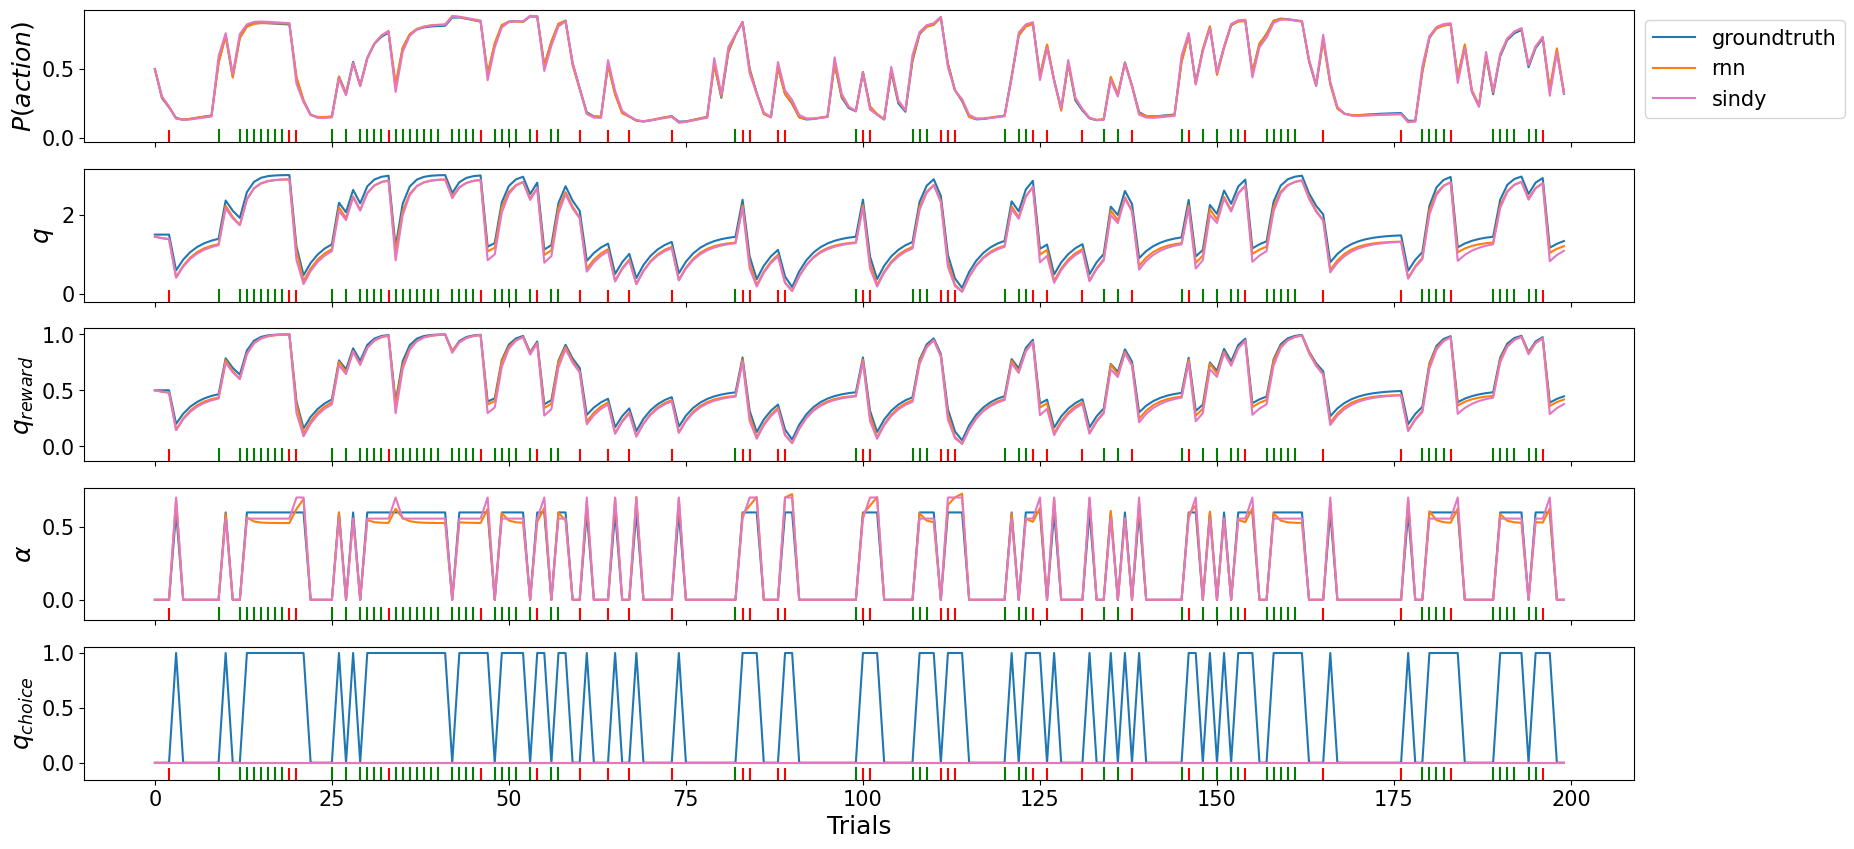

In [10]:
import matplotlib.pyplot as plt
from spice.utils.plotting import plot_session

# get analysis plot
agents = {'groundtruth': agent, 'rnn': spice_estimator.rnn_agent, 'sindy': spice_estimator.sindy_agent}

fig, axs = plot_session(agents, dataset.xs[0])
plt.show()